# Compact Mixed Integer Linear Programming Model for Balancing Bike Sharing Systems 

<!--NAVIGATION-->
[Part 1](Part1.ipynb)

In [3]:
import gurobipy as gb
import networkx as nx
import pygraphviz as pygv
import os
from IPython.display import SVG, display
import pandas as pd

In [1]:
def draw_initial_graph(G, scale):
    global DrawG
    DrawG = pygv.AGraph(strict='true', splines='true', directed=True)
    
    for i in G.nodes():
        pos = str(G.node[i]['x'] * scale) + ',' + str((G.node[i]['y']) * scale)

        if G.node[i]['load'] < 0:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], color='red',
                           style='filled', fillcolor='salmon', fontsize='8', width='0.3')
        elif G.node[i]['load'] > 0:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], color='green',
                           style='filled', fillcolor='palegreen1', fontsize='8', width='0.3')
        else:
            DrawG.add_node(i, shape='circle', pos=pos, label=G.node[i]['label'], fontsize='8', width='0.3')
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw(path=basename + '.svg', format='svg')
    DrawG.clear()
    
    
def draw_solution(G, x, y, vehicles, scale):
    pos = str(G.node['0']['x'] * scale) + ',' + str((G.node['0']['y']) * scale)
    DrawG.add_node('0', shape='circle', pos=pos, label=G.node['0']['label'], fontsize='8', width='0.3')
    pos = str(G.node['1']['x'] * scale) + ',' + str((G.node['1']['y']) * scale)
    DrawG.add_node('1', shape='circle', pos=pos, label=G.node['1']['label'], fontsize='8', width='0.3')
     
    for i in G.nodes()-{'0', '1'}:
        for v in vehicles:
            if x[i, v].x == 1:
                lab = G.node[i]['label']
                t = i.split(" ")
                pos = str(G.node[i]['x'] * float(t[1][0]) * scale) + ',' + str(G.node[i]['y'] * scale)
                if G.node[i]['load'] < 0:
                    DrawG.add_node(i, shape='circle', pos=pos, label=lab, color='red', style='filled', 
                                   fillcolor='salmon', fontsize='8', width='0.1')
                elif G.node[i]['load'] > 0:
                    DrawG.add_node(i, shape='circle', pos=pos, label=lab, color='green', style='filled', 
                                   fillcolor='palegreen1', fontsize='8', width='0.1')
    
    # associate a color to each vehicle
    colors = ['red', 'blue', 'green', 'orange3', 'lightslategrey', 'darkslateblue']
    dict_vehicles = []
    for i in range(0, len(vehicles)):
        dict_vehicles.append({'vehicle': vehicles[i], 'color': colors[i]})
    
    for i, j in G.edges():
        for v in dict_vehicles:
            if y[i, j, v['vehicle']].x == 1:
                lab = "(%s, %s) %s"%(i,j,v['vehicle'])
                DrawG.add_edge(i, j, color=v['color'], label= v['vehicle'], fontsize='8', 
                               splines='spline', fontcolor= v['color'])
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw(path=basename +"_sol" + '.svg', format='svg')
    DrawG.clear()

## Problem Definition

**Given:**

- A set of stations $S$ and a set of homogeneous vehicles $L$.

- A common time budget $\;t̂\;$ (drivers’ shift times) within which they have to finish their routes.

- For each station $s \in S$ the number of full vehicle loads $f_s$ to be delivered $(f_s \le −1)$ or picked up $(f_s \ge 1)$ such that the station achieves its (approximately) ideal target fill level.


**Find:**

The maximum number of full vehicle loads picked up and delivered to the stations, such that the total balance increase in the system.  

A station, to which bikes shall be delivered is called a *delivery station*, while a station from which bikes should be removed is called a *pickup station*. At pickup stations, only pickups may be performed, while at delivery stations, only deliveries, and we never allow more than $|f_s |$ visits at each station.

>**Note**
>
>Stations
that are already at their desired target fill level (or require
less than a full vehicle load) are ignored from any further
consideration.

### Graph

For modeling tours with up to $|f_s |$ visits at each station $s \in S$, a directed bipartite graph $G = (V ,A)$ as been defined as follows. Let

$$V_\text{pic} = \{(s,i)\;|\;s \in S \land f_s \ge 1,\;i=1,...,|f_s|\}$$

be a set of nodes representing up to $|f_s|$ visits at each pickup station, and let

$$V_\text{del} = \{(s,i)\;|\;s \in S \land f_s \le -1,\;i=1,...,f_s\}$$

denote the respective potential visits at the delivery stations. $V=V_\text{pic} \cup V_\text{del}$ then refers to the joined set of all potential visits, and the arc set of graph $G$ is given by

$$ A=\{(u,v),\;(v,u)\;|\;u \in V_\text{pic},\; v \in V_\text{del}\} $$

Further the set of stations $V$ as been extended by two nodes $0$ and $1$ representing the depot at the beginning and the end of each tour, respectively, obtaining $V_0 = V \cup \{0, 1\}$. 

Node $0$ is connected to all pickup nodes, while $1$ is connected to all delivery nodes, that is, $A_0= A \cup \{(0,v) \;|\; v \in V_\text{pic}\} \cup \{(v,1) \;|\; v \in V_\text{del}\}$, yielding a bipartite graph $G_0 = (V_0, A_0)$. 

Each arc $(u, v) \in A_0$ represents an actual trip from the location represented by visit $u$ to the location represented by visit $v$ and has a corresponding traveling time $t_{uv} > 0$ associated.

### Model 

#### Decision variables

$$
x_{vl}=\begin{cases}1 \text { if station visits $v \in V$ is assigned to vehicle $l \in L$}\\
0 \text{ otherwise}
\end{cases}
$$

$$
y\ ^l_{uv}=\begin{cases}1 \text { if arc $(u, v) \in A$ is assigned to vehicle $l \in L$}\\
0 \text{ otherwise}
\end{cases}
$$

$$
a_v=\{ \text{ position in the tour in which the node $v$ is visited }\}
$$

#### Formulation

$$
\begin{alignat}{4}
&\max \sum_{l \in L} \sum_{v \in V} x_{lv} &\\\\
\text{s.t.} \;\;\;\;\;&\\
\\
\sum_{l \in L} x_{vl} &\le 1 \;\;\; \forall v \in V \;\;\; \text{(1)}\\ 
\sum_{v \in V_{\text{pic}}} x_{vl} &= \sum_{v \in V_{\text{del}}} x_{vl} \;\;\; \forall l \in L \;\;\; \text{(2)}\\
\sum_{l' \in L} x_{(s,i)l'} &\ge x_{(s,i+1)l} \;\;\; \forall s \in S ,\; l \in L, \; i = 1,....,f_s-1 \;\;\; \text{(3)}\\
\sum_{v \in V_{\text{pic}}} y\ ^l_{0v} &= 1 \;\;\; \forall l \in L \;\;\; \text{(4)}\\
\sum_{v \in V_{\text{del}}} y\ ^l_{v1} &= 1 \;\;\; \forall l \in L \;\;\; \text{(5)}\\
\sum_{(u,v) \in A_0} y\ ^l_{uv} &= x_{ul} \;\;\; \forall l \in L, \; u \in V \;\;\; \text{(6)}\\
\sum_{(u,v) \in A_0} y\ ^l_{uv} &= x_{vl} \;\;\; \forall l \in L, \; v \in V \;\;\; \text{(7)}\\
\sum_{(u,v) \in A_0} y\ ^l_{uv} &= \sum_{(v,u) \in A_0} y\ ^l_{vu} \;\;\; \forall l \in L, \; v \in V \;\;\; \text{(8)}\\
\sum_{(u,v) \in A_0} t_{uv} \cdot y\ ^l_{uv} &\le \;t̂ \;\;\; \forall l \in L \;\;\; \text{(9)}\\
a_u - a_v + |V| \cdot y\ ^l_{uv} &\le |V| - 1 \;\;\; \forall l \in L,\; (u,v) \in A \;\;\; \text{(10)}\\
\\
x_{vl} &\in \{0,1\} \;\;\; \forall l \in L,\; v \in V\\
y\ ^l_{ul} &\in \{0,1\} \;\;\; \forall l \in L,  \; (u,v) \in A_0\\
1 &\le a_v \le |V| \;\;\; \forall v \in V 
\end{alignat}
$$


## Test on a bigger instance

### Graph description

Here we test the model on a bigger instance. The graph used here is a directed graph made by **152** nodes, representing visits to **20** different stations, and **11368** edges. As before the <span style='color: green'>green</span> nodes are the pickup stations and the <span style='color: red'>red</span> ones are the delivery stations.

The biggest distance time between two stations is **4701**.  

The number of vehicles is <b>4</b> and the time budget is <b>10000</b> seconds.

In [4]:
filename = 'graph_test.gml'
scale = 20

basename = os.path.splitext(filename)[0]

G = nx.read_graphml (filename, node_type=str)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

G has 57 nodes and 1555 edges
True


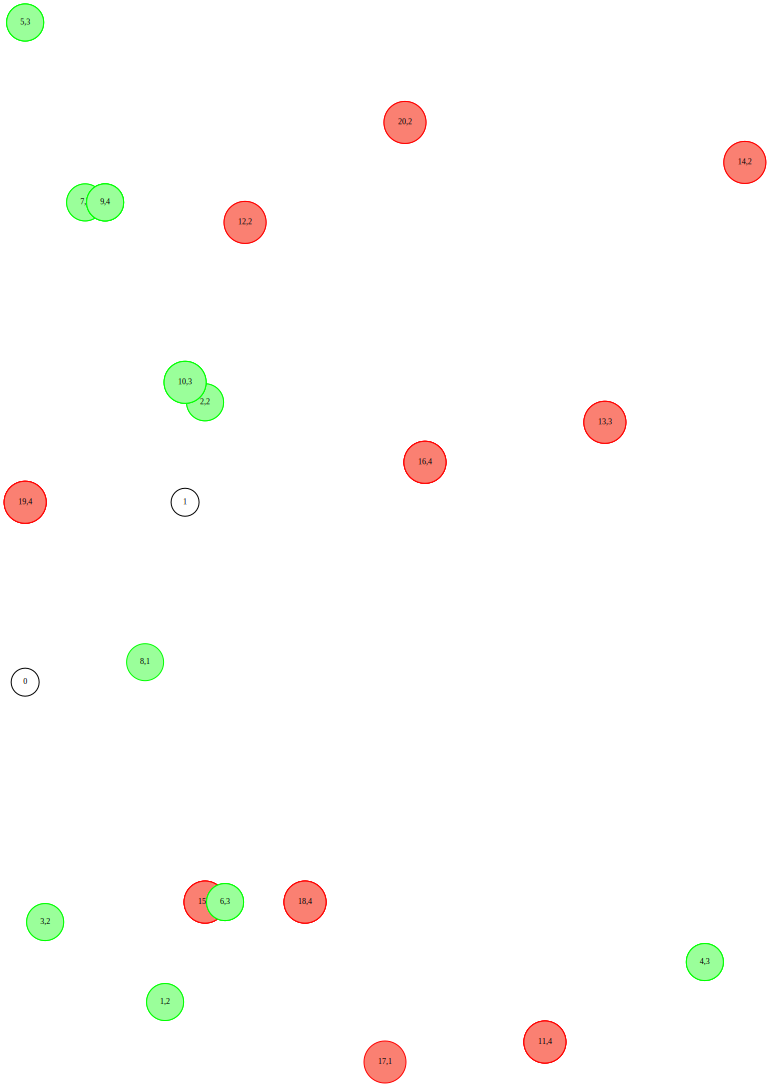

In [5]:
draw_initial_graph(G, scale)
display(SVG(filename=basename+'.svg'))

In [6]:
nodes = pd.DataFrame([i[1] for i in G.nodes(data=True)], index=G.nodes())

In [7]:
nodes

,label,load,station,x,y
"(11, 1)","11,1",-4,11.0,40,8
"(11, 2)","11,2",-4,11.0,40,8
"(11, 3)","11,3",-4,11.0,40,8
"(11, 4)","11,4",-4,11.0,40,8
"(12, 1)","12,1",-2,12.0,25,49
"(12, 2)","12,2",-2,12.0,25,49
"(13, 1)","13,1",-3,13.0,43,39
"(13, 2)","13,2",-3,13.0,43,39
"(13, 3)","13,3",-3,13.0,43,39
"(14, 1)","14,1",-2,14.0,50,52


In [8]:
abs(nodes['load']).max()

4

In [9]:
abs(nodes['load']).min()

0

In [11]:
edges = nx.to_pandas_edgelist(G)

In [12]:
edges

,source,target,time
0,"(11, 1)","(1, 1)",1910
1,"(11, 1)","(1, 2)",1910
2,"(11, 1)","(2, 1)",3623
3,"(11, 1)","(2, 2)",3623
4,"(11, 1)","(3, 1)",2570
5,"(11, 1)","(3, 2)",2570
6,"(11, 1)","(4, 1)",894
7,"(11, 1)","(4, 2)",894
8,"(11, 1)","(4, 3)",894
9,"(11, 1)","(5, 1)",5724


In [13]:
print("Maximum distance time between nodes:",edges['time'].max())

Maximum distance time between nodes: 5724


### Model implementation

In [14]:
L = [i for i in range(1,5)] #4 vehicles
t_budget = 10000         #time budget
start_depot = '0'
end_depot = '1'
stations = [i for i in range(1, 21)]

In [15]:
v_pick = [i for i in G.nodes() if G.node[i]['load'] > 0] # pickup nodes
v_del = [i for i in G.nodes() if G.node[i]['load'] < 0] # delivery nodes
station_visits = G.nodes()-{start_depot, end_depot} # V set

In [16]:
mod = gb.Model()

Academic license - for non-commercial use only


In [17]:
x = mod.addVars(station_visits, L, obj=1, vtype=gb.GRB.BINARY, name='x')

y = mod.addVars(G.edges(), L, vtype=gb.GRB.BINARY, name='y')

a = mod.addVars(G.nodes(), lb=1.0, ub=len(station_visits), vtype=gb.GRB.CONTINUOUS, name='a')

mod.ModelSense = gb.GRB.MAXIMIZE
mod.write('model2.lp')

>#### Constr 1
>
>Every station visit is performed by at most one vehicle

In [18]:
mod.addConstrs((x.sum(v, '*') <= 1 for v in station_visits), name='CSTR1')
mod.update()
mod.write('model2.lp')

>#### Constr 2
>Every tour contains the same amount of pickup visits as delivery visits

In [19]:
for l in L:
    mod.addConstr(gb.quicksum([x[v,l] for v in v_pick]) == gb.quicksum([x[v,l] for v in v_del]), name='CSTR2_%s'%l)
    mod.update()
mod.write('model2.lp')

>#### Constr 3
>The $i + 1$ th visit can only be performed when the $i$ th visit is performed, for $i = 1, . . . , f_s − 1$ and each station $s \in S$.

In [20]:
for s in stations:
    for l in L:
        for i in range(1, abs(G.node[str((s, 1))]['load'])):
            mod.addConstr(x.sum(str((s, i)), '*') >= x[str((s, i+1)), l], name='CSTR3_(%s,%s)_%s' % (s,i,l))
            mod.update()
mod.write('model2.lp')

>#### Constr 4
>For each vehicle the depot’s starting node $0$ has to have one outgoing arc

In [21]:
for l in L:
    mod.addConstr(y.sum(start_depot, v_pick, l) == 1, name='CSTR4_%s'%l)
    mod.update()
mod.write('model2.lp')

>#### Constr 5
>The depot’s target node $1$ has to have one incoming arc

In [22]:
for l in L:
    mod.addConstr(y.sum(v_del,end_depot, l) == 1, name='CSTR5_%s'%l)
    mod.update()
mod.write('model2.lp')

>#### Constr 6
>Every node $u \in V$ has one outgoing arc iff it is assigned to vehicle $l$.

In [23]:
for l in L:
    for u in station_visits:
        mod.addConstr(y.sum(u, '*', l) == x[u, l], name='CSTR6_(%s)_%s'%(u,l))
        mod.update()
mod.write('model2.lp')

>#### Constr 7
>Each node $v \in V$ which is assigned to vehicle $l \in L$ has to have one corresponding ingoing arc.

In [24]:
for l in L:
    for v in station_visits:
        mod.addConstr(y.sum('*', v, l) == x[v, l], name='CSTR7_(%s)_%s'%(v,l))
        mod.update()
mod.write('model2.lp')

>#### Constr 8
>The number of ingoing arcs has to be equal to the number of outgoing arcs foreach node $v \in V,\; l \in L$

In [25]:
for l in L:
    for v in station_visits:
        mod.addConstr(
            y.sum('*', v, l) == y.sum(v, '*', l),
            name = 'CSTR8_%s_%s'%(l,v))
        mod.update()
mod.write('model2.lp')

>#### Constr 9
>The routes for each vehicle has to lie within the allowed time budget.

In [26]:
t = nx.get_edge_attributes(G,'time')

In [27]:
mod.addConstrs((gb.quicksum([t[u, v] * y[u, v, l] for u, v in G.edges()]) <= t_budget for l in L), name = 'CSTR9')
mod.update()
mod.write('model2.lp')

>#### Constr 10
>MTZ subtour inequalities

In [28]:
a[start_depot].lb = 1
a[start_depot].ub = 1

for l in L:
    for u, v in G.edges():
        if u != start_depot and u != end_depot and v != start_depot and v != end_depot: 
            mod.addConstr(
            a[u] - a[v] + len(station_visits) * y[u, v, l] <= len(station_visits) - 1, 
                name='CSTR10_(%s,%s)%s'%(u,v,l))
            mod.update()
mod.write('model2.lp')

In [ ]:
%time mod.optimize()


Consider calling update less frequently.

Optimize a model with 6871 rows, 6497 columns and 50460 nonzeros
Variable types: 57 continuous, 6440 integer (6440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 220 rows and 2 columns
Presolve time: 0.11s
Presolved: 6651 rows, 6495 columns, 37860 nonzeros
Variable types: 55 continuous, 6440 integer (6440 binary)

Root relaxation: objective 4.019048e+01, 4871 iterations, 0.34 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.19048    0  104          -   40.19048      -     -    0s
H    0     0                      10.0000000   40.19048   302%     -    1s
     0     0   40.19048    0  194   10.00000   40.19048   302%     -    2s
     0     0   40.19048    0  155   10.00000   40.19048

 33495 14346   38.02320   77   92   32.00000   40.00000  25.0%  49.6  438s
 33543 14359   39.52289   67  124   32.00000   40.00000  25.0%  49.7  442s
 33602 14367   40.00000   71  133   32.00000   40.00000  25.0%  49.8  445s
 34059 14523   37.75241   83  121   32.00000   40.00000  25.0%  49.9  452s
 34260 14538   38.30950   66  135   32.00000   40.00000  25.0%  50.0  456s
 34387 14554   37.96546   52  126   32.00000   40.00000  25.0%  50.1  463s
 34473 14564   39.23372   68  128   32.00000   40.00000  25.0%  50.2  466s
 34708 14611 infeasible   71        32.00000   40.00000  25.0%  50.3  472s
 34960 14652   38.06687   71  124   32.00000   40.00000  25.0%  50.3  475s
 35503 14742   40.00000   68   93   32.00000   40.00000  25.0%  50.7  481s
 35866 14784   40.00000   70  122   32.00000   40.00000  25.0%  51.0  486s


In [35]:
scale = 30
draw_solution(G, x, y, L, scale)

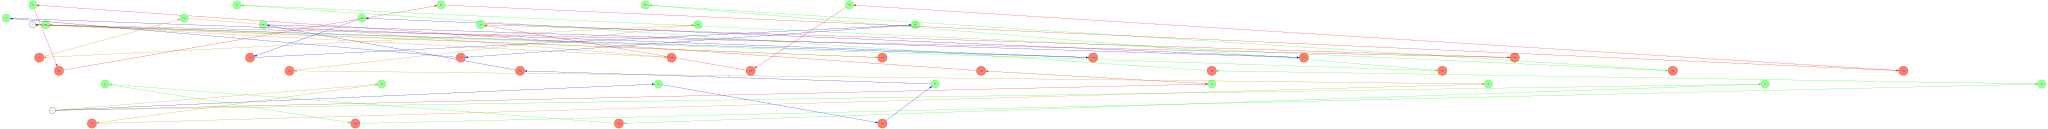

In [5]:
display(SVG(filename=basename+'_sol'+'.svg'))

In [40]:
print("Linear relaxation:",1.420000e+02)
print("Number of visits made:",mod.ObjVal)
print("Explored nodes:", mod.NodeCount)

Linear relaxation: 142.0
Number of visits made: 42.0
Explored nodes: 3666.0


In [37]:
visits_count = {}

for i in station_visits:
    for l in L:
        if x[i, l].x == 1:
            visits_count[l] = visits_count.get(l, 0)+1

In [38]:
visits_count

{2: 12, 4: 10, 3: 10, 1: 10}

In [41]:
total_time = 0
for i, j in G.edges():
    for l in L:
        if y[i, j, l].x == 1:
            total_time += G[i][j]['time']

In [42]:
total_time

35080

### Solution analysis

In this case the solver takes a very long time to find the optimal solution. After **37.51** minutes, it was able to limit the gap from the incumbent to the upper bound of less than **50%**, so the solution analyzed here is far away from being the optimal one. The solution found is **42** visits to the station and it was found exploring **3666** different nodes. The total time required by the vehicles is **35080** seconds. Vehicle _2_ is the one doing more visits, **12**.

The last analysis of this model will be a test where the **start and ending depots are the same**. This situation better reflects the reality, since usually vehicles start from a depot and return to the same when they have finished their job.

<a href="./Part3.ipynb">Part 3</a>